In [1]:
# Now that we got the data from Top 50 restaurants, we will starting making our machine learning project. 
# It will predict the number of meals served in any restaurant based on all of the other factors.

# assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
# assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# We will work with another set of data: top 100 restaurants (50 is way too small for the number of entries for Machine Learning) - Independence100 - businesses from USA.

import pandas as pd
csv_file = "Independence100.csv"

def load_restaurants_data():
    return pd.read_csv(csv_file)

In [3]:
# see some rows
restaurants = load_restaurants_data()
restaurants.head()

Rank                           Restaurant       Sales  Average Check  \
0     1             Carmine's (Times Square)  39080335.0             40   
1     2                The Boathouse Orlando  35218364.0             43   
2     3                     Old Ebbitt Grill  29104017.0             33   
3     4  LAVO Italian Restaurant & Nightclub  26916180.0             90   
4     5             Bryant Park Grill & Cafe  26900000.0             62   

         City State  Meals Served  
0    New York  N.Y.      469803.0  
1    Orlando   Fla.      820819.0  
2  Washington  D.C.      892830.0  
3    New York  N.Y.      198500.0  
4    New York  N.Y.      403000.0

In [4]:
# Get the info about the dataset.
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           100 non-null    int64  
 1   Restaurant     100 non-null    object 
 2   Sales          100 non-null    float64
 3   Average Check  100 non-null    int64  
 4   City           100 non-null    object 
 5   State          100 non-null    object 
 6   Meals Served   100 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [5]:
# See how many restaurants from each state.
restaurants["State"].value_counts()

N.Y.      21
Ill.      18
Calif.    12
Nev.      11
D.C.       9
Fla.       9
Texas      3
Ind.       2
Ga.        2
Mich.      2
N.J.       2
Tenn.      2
N.C.       1
Pa.        1
Mass.      1
Ore.       1
Fla.       1
Colo.      1
Va.        1
Name: State, dtype: int64

In [6]:
# Get some statistics about the data.
restaurants.describe()

Rank         Sales  Average Check   Meals Served
count  100.000000  1.000000e+02     100.000000     100.000000
mean    50.500000  1.783343e+07      69.050000  317166.660000
std     29.011492  5.010408e+06      34.735181  192211.390011
min      1.000000  1.139168e+07      17.000000   87070.000000
25%     25.750000  1.409484e+07      39.000000  189492.500000
50%     50.500000  1.730078e+07      65.500000  257097.000000
75%     75.250000  1.990392e+07      95.000000  372079.000000
max    100.000000  3.908034e+07     194.000000  959026.000000

Saving figure attribute_histogram_plots


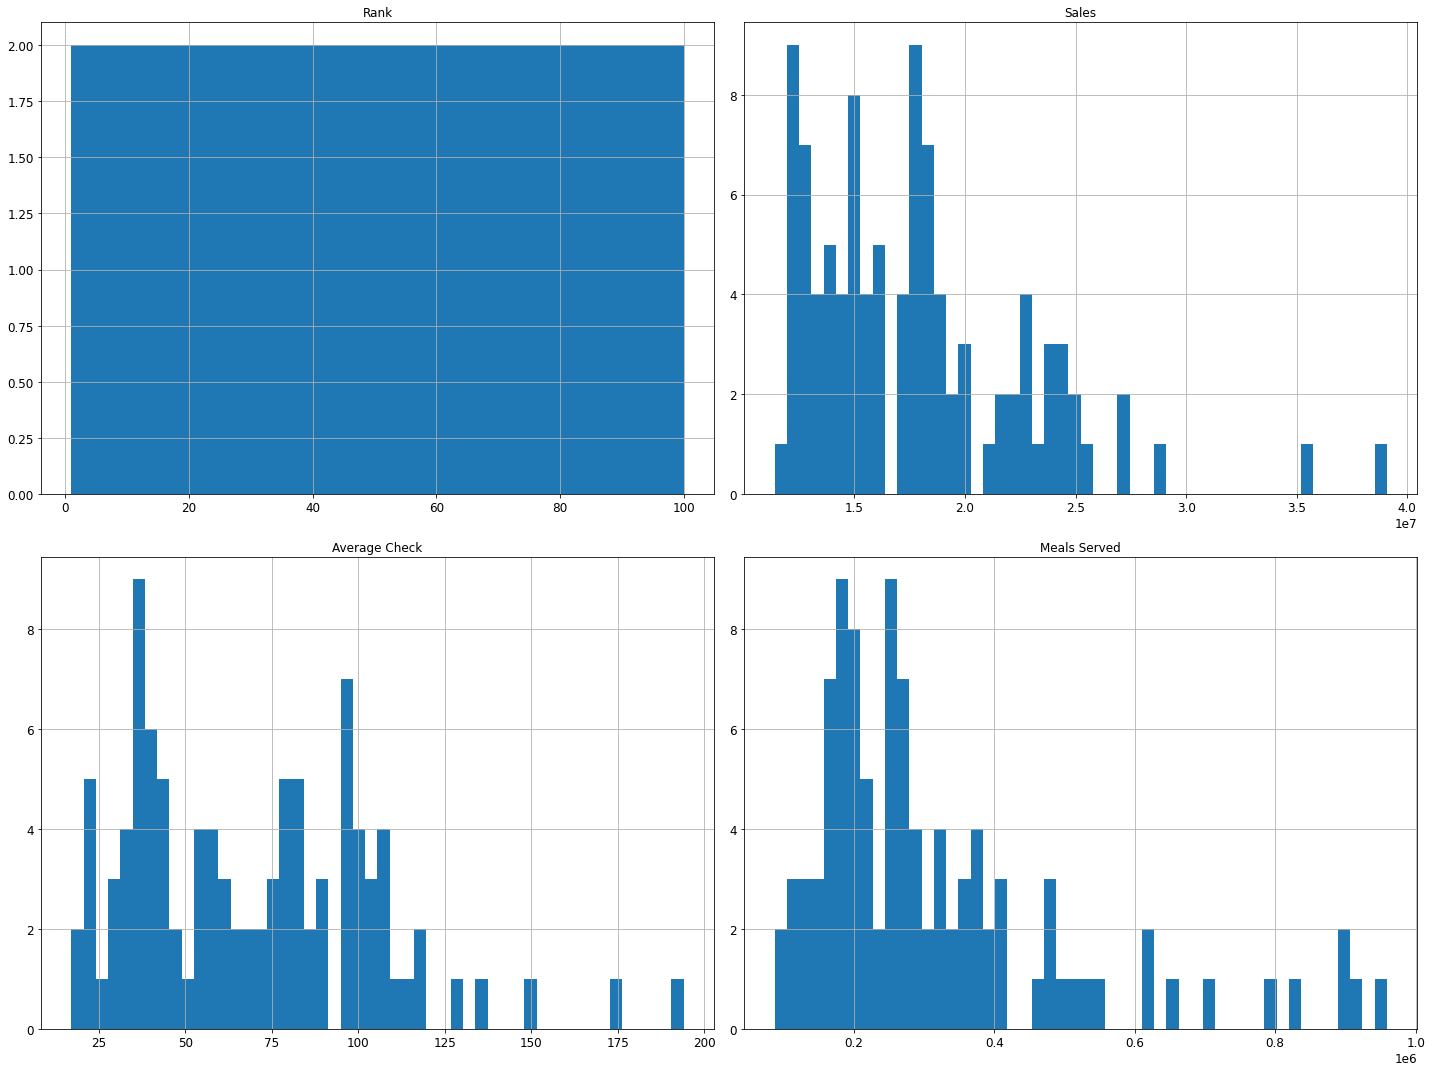

In [7]:
# Visualize data with the help of some histograms - for each attribute.

%matplotlib inline
import matplotlib.pyplot as plt

restaurants.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [8]:
# set the random function to give the same random results every time, so the Machine Learning will not get the data it has to predict.
np.random.seed(42)

In [9]:
# Split the data into train set and test set. The Machine Learning program will learn on the train set (90 entries) and test its predictions on the test set (10 entries).

import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
# Test if the split works.
train_set, test_set = split_train_test(restaurants, 0.1)
len(test_set)

10

In [11]:
# Apply a hash function on the ranks, so the test data will remain consistent (will not change over updates).

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
# Create the sets
train_set, test_set = split_train_test_by_id(restaurants, 0.1, "Rank")

In [17]:
test_set

Rank                           Restaurant       Sales  Average Check  \
22    23                 St. Elmo Steak House  21422141.0             99   
24    25                         Mon Ami Gabi  20120210.0             76   
29    30               Bob Chinn's Crab House  18687601.0             48   
34    35                         Le Diplomate  18490719.0             38   
35    36             Gibsons Bar & Steakhouse  18483056.0             79   
41    42  Founding Farmers (Washington, D.C.)  17910045.0             33   
44    45               Chicago Cut Steakhouse  17743720.0             95   
65    66                                 Swan  15000000.0             78   
68    69                     Acme Feed & Seed  14897125.0             22   
74    75           Beauty & Essex (Las Vegas)  14130500.0             99   

            City  State  Meals Served  
22  Indianapolis   Ind.      192774.0  
24     Las Vegas   Nev.      319200.0  
29      Wheeling   Ill.      625907.0  
34    Washington   D.C.      363609.0  
35      Rosemont   Ill.      252419.0  
41    Washington   D.C.      648096.0  
44       Chicago   Ill.      211000.0  
65         Miami   Fla.      225000.0  
68     Nashville  Tenn.      527130.0  
74     Las Vegas   Nev.      150000.0

<AxesSubplot:>

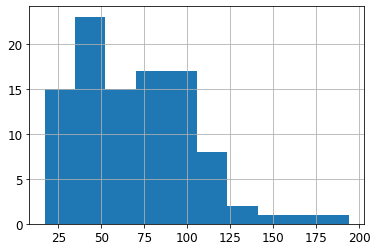

In [18]:
restaurants["Average Check"].hist()

In [19]:
# Split "Average Check" into 5 categories (on intervals).

restaurants["check_cat"] = pd.cut(restaurants["Average Check"],
                               bins=[0, 50, 100, 150, 200, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [23]:
restaurants["check_cat"].value_counts()

2    47
1    37
3    14
4     2
5     0
Name: check_cat, dtype: int64

<AxesSubplot:>

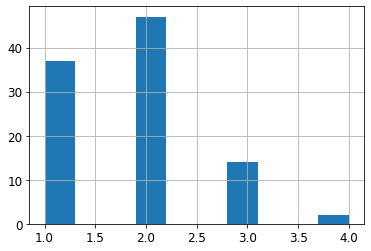

In [24]:
restaurants["check_cat"].hist()

In [34]:
# Let's get the proportions of each category now. We will use 3 decimals (shows with 6 decimals), to not get the value 0 for the 4th category.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(restaurants, restaurants["check_cat"]):
    strat_train_set = restaurants.loc[train_index]
    strat_test_set = restaurants.loc[test_index]

In [37]:
strat_test_set["check_cat"].value_counts() / len(strat_test_set)
strat_train_set["check_cat"].value_counts() / len(strat_train_set)

2    0.471429
1    0.371429
3    0.142857
4    0.014286
5    0.000000
Name: check_cat, dtype: float64

In [38]:
restaurants["check_cat"].value_counts() / len(restaurants)

# As we can notice, the total dataset, the train set and the test set give almost the same ratios of categories of "Average Check".

2    0.47
1    0.37
3    0.14
4    0.02
5    0.00
Name: check_cat, dtype: float64

In [40]:
# Let's see the exact differences (errors) between the 3 sets (overall, train, test).

def income_cat_proportions(data):
    return data["check_cat"].value_counts() / len(data)

train_set, test_set = split_train_test_by_id(restaurants, 0.1, "Rank")

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(restaurants),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [41]:
compare_props

Overall  Stratified  Random  Rand. %error  Strat. %error
1     0.37    0.366667     0.4      8.108108      -0.900901
2     0.47    0.466667     0.6     27.659574      -0.709220
3     0.14    0.133333     0.0   -100.000000      -4.761905
4     0.02    0.033333     0.0   -100.000000      66.666667
5     0.00    0.000000     0.0           NaN            NaN

In [42]:
# Moving forward, we will discover and visualize the data into plots to get a better understanding of it.

for set_ in (strat_train_set, strat_test_set):
    set_.drop("check_cat", axis=1, inplace=True)

In [43]:
restaurants = strat_train_set.copy()

Saving figure bad_visualization_plot


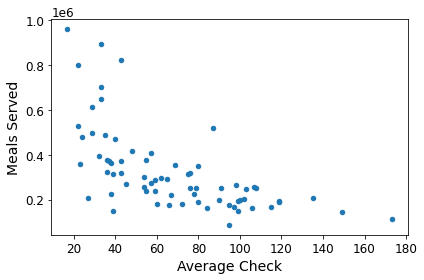

In [44]:
restaurants.plot(kind="scatter", x='Average Check', y='Meals Served')
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


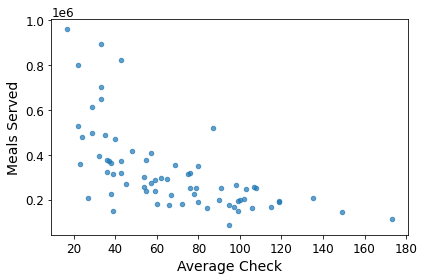

In [53]:
# Because the dataset is small, we barely can notice a difference, when adding alpha value.

restaurants.plot(kind="scatter", x="Average Check", y="Meals Served", alpha=0.7)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


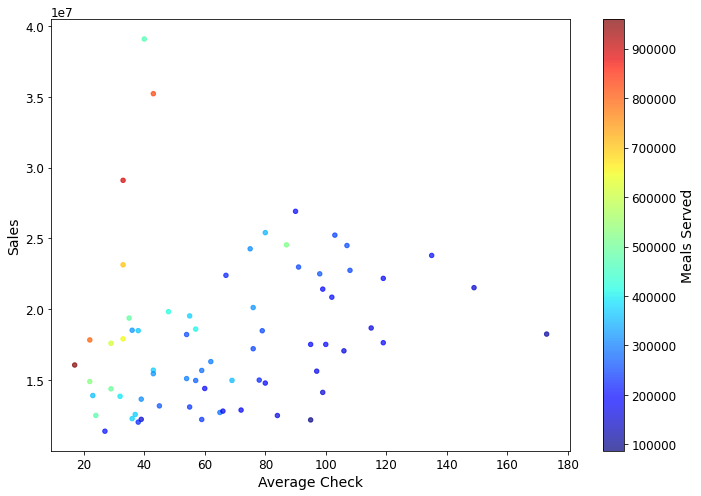

In [62]:
# Let's see now a more representative plot. We can notice that the less a restaurant is checked, the more meals it serves, which is pretty common sense.

restaurants.plot(kind="scatter", x="Average Check", y="Sales", alpha=0.7,
             figsize=(10,7), c="Meals Served", cmap=plt.get_cmap("jet"), 
             colorbar=True, sharex=False)
save_fig("housing_prices_scatterplot")

In [63]:
# Since the data set is rather small, we can easily comute the standard correlation coefficient between every pairs of attributes.

corr_matrix = restaurants.corr()

In [65]:
# The Meals Served actually is almost inverse proportional with the Average Check (-0.62 is close to -1), as we already noticed in the graph above.

corr_matrix["Meals Served"].sort_values(ascending=False)

Meals Served     1.000000
Sales            0.309166
Rank            -0.238106
Average Check   -0.626855
Name: Meals Served, dtype: float64

Saving figure scatter_matrix_plot


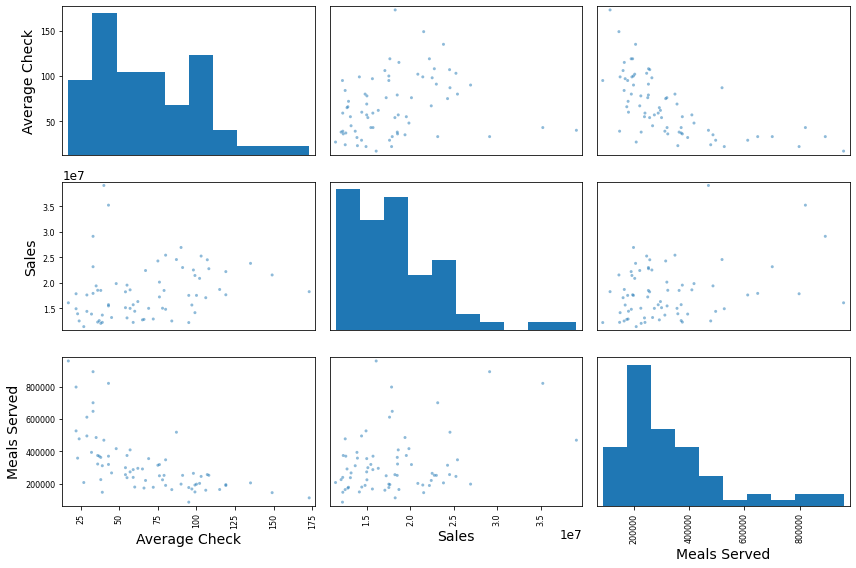

In [66]:
# from pandas.tools.plotting import scatter_matrix
# Now let's use another function to check the correlation between attributes.

from pandas.plotting import scatter_matrix

attributes = ["Average Check", "Sales", "Meals Served"]
scatter_matrix(restaurants[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure unit_volume_vs_units_scatterplot


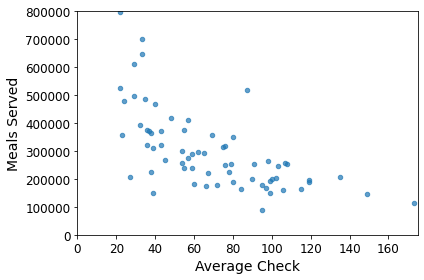

In [70]:
# Because we have used a small dataset, we cannot indentify a strong correlation between 2 attributes. 
# The best attribute to predict the Meals Served is the Average Check, whilst a downward trend is clearly seen (even though some points are a little dispersed).

restaurants.plot(kind="scatter", x="Average Check", y="Meals Served", alpha=0.7)
plt.axis([0, 175, 0, 800000])
save_fig("unit_volume_vs_units_scatterplot")

In [74]:
# Next, we will create a new attribute.
# We will notice that sales_per_check is much more correlated with the Meals Served (0.88 compared to -0.62). Also, they are direct proportional.

restaurants["sales_per_check"] = restaurants["Sales"] / restaurants["Average Check"]

corr_matrix = restaurants.corr()
corr_matrix["Meals Served"].sort_values(ascending=False)

Meals Served       1.000000
sales_per_check    0.884990
Sales              0.309166
Rank              -0.238106
Average Check     -0.626855
Name: Meals Served, dtype: float64

In [75]:
# In the following section we are going to prepare the data for Machine Learning Algorithms.

# Firstly, let's separate the predictors and the labels

restaurants = strat_train_set.drop("Meals Served", axis=1) # drop labels for training set
restaurants_labels = strat_train_set["Meals Served"].copy()

In [76]:
sample_incomplete_rows = restaurants[restaurants.isnull().any(axis=1)].head()
sample_incomplete_rows

Empty DataFrame
Columns: [Rank, Restaurant, Sales, Average Check, City, State]
Index: []

In [86]:
# We will use the median strategy next. For that, we will create a copy of data without the the non-numerical attributes.
# For dataset with some missing data, there can be used the Imputer module. But it is not needed in our case.

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [87]:
restaurants_num = restaurants.drop(['Restaurant', 'City', 'State'], axis=1)

In [88]:
imputer.fit(restaurants_num)

SimpleImputer(strategy='median')

In [89]:
imputer.statistics_

array([4.8500000e+01, 1.7519015e+07, 6.1000000e+01])

In [90]:
restaurants_num.median().values

array([4.8500000e+01, 1.7519015e+07, 6.1000000e+01])

In [92]:
X = imputer.transform(restaurants_num)

In [93]:
restaurants_tr = pd.DataFrame(X, columns = restaurants_num.columns,
                          index = restaurants.index)

In [94]:
restaurants_tr.loc[sample_incomplete_rows.index.values]

Empty DataFrame
Columns: [Rank, Sales, Average Check]
Index: []

In [164]:
imputer.strategy

'median'

In [95]:
restaurants_tr = pd.DataFrame(X, columns = restaurants_num.columns,
                          index = restaurants_num.index)

In [96]:
restaurants_tr.head()

Rank       Sales  Average Check
30  31.0  18678000.0          115.0
69  70.0  14790123.0           80.0
67  68.0  14972300.0           57.0
21  22.0  21523650.0          149.0
27  28.0  19530159.0           55.0

In [97]:
# As most Machine Learning Algorithms prefer to work with numbers, we will convert the State attribute to numbers.

restaurants_cat = restaurants[["State"]]
restaurants_cat.head(10)

State
30    N.Y.
69    Ill.
67     Ga.
21    Nev.
27   Texas
89   Texas
9     N.Y.
86  Calif.
24    Nev.
59    Ill.

In [98]:
# Get their conversion.

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
restaurants_cat_encoded = ordinal_encoder.fit_transform(restaurants_cat)
restaurants_cat_encoded[:10]

array([[11.],
       [ 5.],
       [ 4.],
       [12.],
       [15.],
       [15.],
       [11.],
       [ 0.],
       [12.],
       [ 5.]])

In [99]:
ordinal_encoder.categories_

[array(['Calif.', 'D.C.', 'Fla.', 'Fla. ', 'Ga.', 'Ill.', 'Ind.', 'Mass.',
        'Mich.', 'N.C.', 'N.J.', 'N.Y.', 'Nev.', 'Pa.', 'Tenn.', 'Texas'],
       dtype=object)]

In [100]:
# Convert categorical values into one-hot vectors.

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
restaurants_cat_1hot = cat_encoder.fit_transform(restaurants_cat)
restaurants_cat_1hot

<70x16 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Row format>

In [103]:
restaurants_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [104]:
cat_encoder.categories_

[array(['Calif.', 'D.C.', 'Fla.', 'Fla. ', 'Ga.', 'Ill.', 'Ind.', 'Mass.',
        'Mich.', 'N.C.', 'N.J.', 'N.Y.', 'Nev.', 'Pa.', 'Tenn.', 'Texas'],
       dtype=object)]

In [135]:
# We will add now the new attribute of combined attributes.

from sklearn.base import BaseEstimator, TransformerMixin

col_names = "Sales", "Average Check"
sales_ix, checks_ix = [restaurants_num.columns.get_loc(c) for c in col_names] # get the column indices

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_sales_per_check = True): # no *args or **kargs
        self.add_sales_per_check = add_sales_per_check
    def fit(self, X, y = None):
        return self  # nothing else to do
    def transform(self, X, y = None):
        sales_per_check = X[:, sales_ix] / X[:, checks_ix]
        if self.add_sales_per_check:
            return np.c_[X, sales_per_check]
        else:
            return np.c_[X]

attr_adder = CombinedAttributesAdder(add_sales_per_check = True)
restaurants_extra_attribs = attr_adder.transform(restaurants_num.values)

In [138]:
restaurants_extra_attribs = pd.DataFrame(
    restaurants_extra_attribs,
    columns = list(restaurants_num.columns)+["sales_per_check"],
    index = restaurants_num.index)
restaurants_extra_attribs.head()

Rank       Sales  Average Check  sales_per_check
30  31.0  18678000.0          115.0    162417.391304
69  70.0  14790123.0           80.0    184876.537500
67  68.0  14972300.0           57.0    262671.929825
21  22.0  21523650.0          149.0    144454.026846
27  28.0  19530159.0           55.0    355093.800000

In [139]:
# As we can notice, some data is represented by larger values from other data (different ranges). That might be an issue for the Machine Learning algorithms. 
# We will use some scaler methods to transform the data (map it to different values).

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

restaurants_num_tr = num_pipeline.fit_transform(restaurants_num)

In [140]:
restaurants_num_tr

array([[-6.22487735e-01,  1.00945958e-01,  1.43142390e+00,
        -8.82787127e-01],
       [ 6.99995935e-01, -6.27075213e-01,  3.81427326e-01,
        -7.72178475e-01],
       [ 6.32176260e-01, -5.92961810e-01, -3.08570421e-01,
        -3.89045324e-01],
       [-9.27676274e-01,  6.33805780e-01,  2.45142057e+00,
        -9.71254582e-01],
       [-7.24217248e-01,  2.60516282e-01, -3.68570225e-01,
         6.61215087e-02],
       [ 1.37819269e+00, -1.05493657e+00, -1.29856719e+00,
         8.83436261e-01],
       [-1.33459433e+00,  1.19132698e+00,  1.19142468e+00,
        -5.54967669e-01],
       [ 1.27646318e+00, -1.01595137e+00, -6.85712047e-02,
        -7.19412599e-01],
       [-8.25946761e-01,  3.71005791e-01,  2.61427718e-01,
        -3.78862266e-01],
       [ 3.60897558e-01, -4.60442036e-01, -2.48570617e-01,
        -3.73823586e-01],
       [-7.99303317e-02, -1.01013653e-01, -1.14856768e+00,
         1.30613008e+00],
       [ 9.71274637e-01, -8.02207856e-01, -1.05856797e+00,
      

In [141]:
# Now it's time to add the State

from sklearn.compose import ColumnTransformer

num_attribs = list(restaurants_num)
cat_attribs = ["State"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

restaurants_prepared = full_pipeline.fit_transform(restaurants)

In [149]:
restaurants_prepared

<70x20 sparse matrix of type '<class 'numpy.float64'>'
	with 350 stored elements in Compressed Sparse Row format>

In [150]:
restaurants_prepared.shape

(70, 20)

In [163]:
# IT'S TIME! All of the data is prepared. We are ready to select and train a Machine Learning model.

# 1. Train a Linear Regression model.

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(restaurants_prepared, restaurants_labels)

LinearRegression()

In [175]:
# let's try the full preprocessing pipeline on a few training instances

some_data = restaurants.iloc[:10]
some_labels = restaurants_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [205471.67993483 190388.64922679 273997.90095296 166598.34167073
 409823.52573205 469615.41346409 235836.26513979 185318.16723264
 253822.05121639 265236.41483195]


In [176]:
print("Labels:", list(some_labels))

Labels: [165148.0, 190616.0, 274000.0, 145700.0, 375241.0, 478000.0, 257364.0, 292000.0, 319200.0, 287900.0]


In [179]:
# As we can notice, most of the prediction are quite satisfying:
# 205471.67993483 to 165148.0
# 190388.64922679 to 190616.0
# 273997.90095296 to 274000.0 - the best one
# ...
# 185318.16723264 to 292000.0
# etc

In [184]:
# Below, we are measuring this regression model's RMSE.

from sklearn.metrics import mean_squared_error

restaurants_predictions = lin_reg.predict(restaurants_prepared)
lin_mse = mean_squared_error(restaurants_labels, restaurants_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

71141.61901493507

In [185]:
# 2. Train a Decesion Tree Regressor model.

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(restaurants_prepared, restaurants_labels)

restaurants_predictions = tree_reg.predict(restaurants_prepared)
tree_mse = mean_squared_error(restaurants_labels, restaurants_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# The error is 0. That is not possible, it is more likely that the model has badly overfit the data.

0.0

In [187]:
# We will evaluate this last model in another way then. We will use Cross-Validation.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, restaurants_prepared, restaurants_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [188]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 52360.70195153  82678.69453234 213279.57710714 180784.58459172
  69796.27114272  76469.59835031  76128.48676791  85186.47933295
 190349.02748898 103716.18761519]
Mean: 113074.96088807758
Standard deviation: 55362.79202899218


In [189]:
lin_scores = cross_val_score(lin_reg, restaurants_prepared, restaurants_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 33802.61145134  69196.3678483  156126.088256   193789.82805323
  94174.89305691  76051.3876876   66033.69257498  73930.25053857
  79770.15936943 110437.88333817]
Mean: 95331.31621745465
Standard deviation: 44742.22523650312


In [200]:
# At this point, we have to go through some ways to fine-tune the models we have, assuming that we have some promising models.

# 1. Grid Search.

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(restaurants_prepared, restaurants_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [201]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 10}

In [202]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=10, random_state=42)

In [203]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

124878.6243424085 {'max_features': 2, 'n_estimators': 3}
104915.30959000556 {'max_features': 2, 'n_estimators': 10}
98133.83245850602 {'max_features': 2, 'n_estimators': 30}
130691.32594658373 {'max_features': 4, 'n_estimators': 3}
106137.90698053909 {'max_features': 4, 'n_estimators': 10}
99112.73711524502 {'max_features': 4, 'n_estimators': 30}
129528.70860468279 {'max_features': 6, 'n_estimators': 3}
99186.97375548651 {'max_features': 6, 'n_estimators': 10}
97470.03934006342 {'max_features': 6, 'n_estimators': 30}
103446.92622838818 {'max_features': 8, 'n_estimators': 3}
91574.77340244185 {'max_features': 8, 'n_estimators': 10}
92702.15194773348 {'max_features': 8, 'n_estimators': 30}
117709.58859816479 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
105592.71287208289 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
117185.89113482686 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
100330.65008210602 {'bootstrap': False, 'max_features': 3, 'n_estima

In [204]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.006995      0.002606         0.001799    3.995181e-04   
1        0.020986      0.001097         0.002399    4.903300e-04   
2        0.040176      0.006610         0.004000    1.553237e-03   
3        0.011192      0.002640         0.001998    1.239777e-06   
4        0.018589      0.009723         0.001799    7.480225e-04   
5        0.057368      0.015784         0.004797    1.165144e-03   
6        0.006996      0.001788         0.001399    4.888506e-04   
7        0.022387      0.003877         0.002998    3.693565e-07   
8        0.045974      0.008217         0.004797    7.487743e-04   
9        0.007196      0.002559         0.001599    4.898820e-04   
10       0.014990      0.001789         0.001999    9.172146e-07   
11       0.044976      0.002097         0.004599    8.011950e-04   
12       0.005598      0.001744         0.001597    7.975234e-04   
13       0.012193      0.002225         0.002400    4.911922e-04   
14       0.006197      0.002568         0.001396    4.856097e-04   
15       0.011194      0.002991         0.001599    4.892980e-04   
16       0.004198      0.000748         0.000999    3.504023e-07   
17       0.011194      0.001166         0.001999    9.122432e-07   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}      -5.597091e+09   
1             {'max_features': 2, 'n_estimators': 10}      -4.175801e+09   
2             {'max_features': 2, 'n_estimators': 30}      -5.134935e+09   
3              {'max_features': 4, 'n_estimators': 3}      -7.620216e+09   
4             {'max_features': 4, 'n_estimators': 10}      -4.650865e+09   
5             {'max_features': 4, 'n_estimators': 30}      -5.148256e+09   
6              {'max_features': 6, 'n_estimators': 3}      -4.477256e+09   
7             {'max_features': 6, 'n_estimators': 10}      -3.055619e+09   
8             {'max_features': 6, 'n_estimators': 30}      -3.979363e+09   
9              {'max_features': 8, 'n_estimators': 3}      -2.465555e+09   
10            {'max_features': 8, 'n_estimators': 10}      -2.008430e+09   
11            {'max_features': 8, 'n_estimators': 30}      -2.881835e+09   
12  {'bootstrap': False, 'max_features': 2, 'n_est...      -6.515988e+09   
13  {'bootstrap': False, 'max_features': 2, 'n_est...      -3.239339e+09   
14  {'bootstrap': False, 'max_features': 3, 'n_est...      -9.577989e+09   
15  {'bootstrap': False, 'max_features': 3, 'n_est...      -4.504046e+09   
16  {'bootstrap': False, 'max_features': 4, 'n_est...      -4.805469e+09   
17  {'bootstrap': False, 'max_features': 4, 'n_est...      -3.476373e+09   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0       -2.611355e+10  ...    -1.559467e+10  

In [205]:
# 2. Randomized Search. When exploring more combinations.

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(restaurants_prepared, restaurants_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019F33D3E850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019F33D3EC40>},
                   random_state=42, scoring='neg_mean_squared_error')

In [206]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

93506.28085110527 {'max_features': 7, 'n_estimators': 180}
100658.88241045864 {'max_features': 5, 'n_estimators': 15}
100435.26101738664 {'max_features': 3, 'n_estimators': 72}
99031.85810098596 {'max_features': 5, 'n_estimators': 21}
91751.72212988582 {'max_features': 7, 'n_estimators': 122}
100766.84629545371 {'max_features': 3, 'n_estimators': 75}
101272.92741576885 {'max_features': 3, 'n_estimators': 88}
93955.63629316237 {'max_features': 5, 'n_estimators': 100}
101358.42302964197 {'max_features': 3, 'n_estimators': 150}
117701.7988935841 {'max_features': 5, 'n_estimators': 2}


In [210]:
# Finally, we will analyze the best models and their errors.

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.02875860e-01, 3.85565710e-02, 1.14758134e-01, 6.40669565e-01,
       4.95266663e-03, 3.35968019e-02, 6.47784283e-03, 3.57003247e-03,
       1.18807370e-04, 1.30712242e-03, 3.09771234e-04, 1.88611240e-04,
       1.72758262e-03, 8.04250695e-04, 1.91346090e-04, 2.36061565e-02,
       3.22172218e-04, 1.37605279e-02, 2.61736444e-03, 9.58881312e-03])

In [211]:
extra_attribs = ["sales_per_check"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.6406695653326311, 'sales_per_check'),
 (0.11475813354112589, 'Average Check'),
 (0.10287586045033402, 'Rank'),
 (0.03855657096666559, 'Sales'),
 (0.03359680190535593, 'D.C.'),
 (0.023606156527757688, 'N.Y.'),
 (0.013760527886326953, 'Pa.'),
 (0.00958881312438068, 'Texas'),
 (0.0064778428338580695, 'Fla.'),
 (0.004952666627096056, 'Calif.'),
 (0.003570032474863229, 'Fla. '),
 (0.0026173644419077947, 'Tenn.'),
 (0.0017275826221765029, 'Mich.'),
 (0.001307122416981745, 'Ill.'),
 (0.0008042506953302415, 'N.C.'),
 (0.0003221722183792288, 'Nev.'),
 (0.0003097712343536301, 'Ind.'),
 (0.00019134609021231037, 'N.J.'),
 (0.0001886112399588649, 'Mass.'),
 (0.00011880737030470606, 'Ga.')]